## xcube Data Store Framework – Sentinel Hub Data Store

### Generating a larger Zarr datacube from Sentinel 2 Level-2A data 

**Please note:**

In order to access data from Sentinel Hub, you need Sentinel Hub API credentials. They may be passed as store parameters (see further below) or exported from environment variables. In case you have not exported them already, you _may_ also set them by uncommenting the cell below and adjusting the content to your access credentials. However, we do not recommend this method!

* Within DeepESDL there is the possiblity to apply for SentinelHub access - please contact the DeepESDL team :)
* This notebook runs with the python environment `users-deepesdl-xcube-1.9.1`, please checkout the documentation for [help on changing the environment](https://deepesdl.readthedocs.io/en/latest/guide/jupyterlab/#python-environment-selection-of-the-jupyter-kerne).**

In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr

# mandatory imports
from xcube.core.store import find_data_store_extensions
from xcube.core.store import get_data_store_params_schema
from xcube.core.store import new_data_store
from zappend.api import zappend

### Access data from Sentinel Hub

The xcube plugin `xcube-sh` provides a data store named `sentinelhub` that can be used to access Sentinel data in form 3-d datacubes of type `xarray.Dataset`.

In [2]:
sh_store = new_data_store('sentinelhub', num_retries=400)

Which datasets are supported by this data store?

In [3]:
list(sh_store.get_data_ids())

['S2L1C', 'S1GRD', 'S2L2A', 'DEM']

Describe the S2L2A dataset. The `open_params_schema` describes the parameters that can be passed to the data store's `open_data()` method.

In [4]:
sh_store.describe_data('S2L2A')

Let's open a subset of this dataset to familiarize with its representation as an `xarray.Dataset`. The dataset is opened lazily, that is, data is loaded only at the time it is needed:

In [5]:
s2_cube = sh_store.open_data(
    'S2L2A',
    variable_names=['B02','B03','B04'],
    tile_size=[1024, 1024],
    spatial_res=0.00018,   # = 20.038 meters in degree
    bbox=[10.0, 54.27, 11.0, 54.6],
    time_range=[f'2023-07-08', f'2023-07-12'],
    time_period='1D'
)
s2_cube

<xarray.Dataset> Size: 755MB
Dimensions:    (time: 5, lat: 2048, lon: 6144, bnds: 2)
Coordinates:
  * lat        (lat) float64 16kB 54.64 54.64 54.64 54.64 ... 54.27 54.27 54.27
  * lon        (lon) float64 49kB 10.0 10.0 10.0 10.0 ... 11.11 11.11 11.11
  * time       (time) datetime64[ns] 40B 2023-07-08T12:00:00 ... 2023-07-12T1...
    time_bnds  (time, bnds) datetime64[ns] 80B dask.array<chunksize=(5, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B02        (time, lat, lon) float32 252MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B03        (time, lat, lon) float32 252MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B04        (time, lat, lon) float32 252MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
Attributes: (12/13)
    Conventions:               CF-1.7
    title:                     S2L2A Data Cube Subset
    history:                   [{'program': 'xcube_sh.chunkstore.SentinelHubC...
    date_created:              2025-05-22T10:24:21.463611
    time_coverage_start:       2023-07-08T00:00:00+00:00
    time_coverage_end:         2023-07-13T00:00:00+00:00
    ...                        ...
    time_coverage_resolution:  P1DT0H0M0S
    geospatial_lon_min:        10.0
    geospatial_lat_min:        54.27
    geospatial_lon_max:        11.10592
    geospatial_lat_max:        54.63864
    processing_level:          L2A

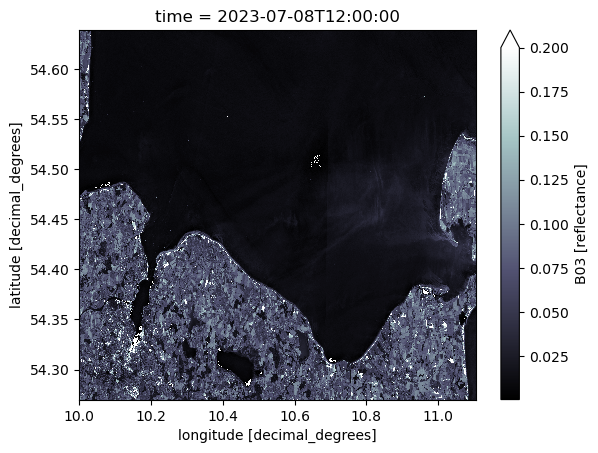

In [6]:
s2_cube.B03.isel(time=0).plot.imshow(vmax=0.2, cmap="bone")

The dataset `s2_cube` could be written to Zarr by simply using `s2_cube.to_zarr(path)` but that approach is not appropriate for larger datacubes for several reasons:

- Sentinel Hub may lower bandwidth due to the very many concurrent API requests it receives for each written chunk of our datacube.
- Your Sentinel Hub subscription may run out of credits. 
- Network errors while reading or filesystem errors while writing may occur unexpectedly at any time.
- Potential, yet undiscovered memory leaks in the involved libraries may lead to out-of-memory conditions. 

Therefore we will introduce a new tool **zappend** that can avoid or at least mitigate some of the issues above. Before that we discuss the _team storage_ where you can persist your datacubes.

### Access team storage

The DeepESDL team storage is a special writable bucket in AWS S3 object storage that is used by your team to allow for shared access of datasets.
The xcube software provides an data store of type `s3` to access datasets in object storage.

In [7]:
S3_USER_STORAGE_KEY = os.environ["S3_USER_STORAGE_KEY"]
S3_USER_STORAGE_SECRET = os.environ["S3_USER_STORAGE_SECRET"]
S3_USER_STORAGE_BUCKET = os.environ["S3_USER_STORAGE_BUCKET"]

In [8]:
team_store = new_data_store(
    "s3", 
    root=S3_USER_STORAGE_BUCKET, 
    storage_options=dict(
        anon=False, 
        key=S3_USER_STORAGE_KEY, 
        secret=S3_USER_STORAGE_SECRET
    )
)

Which datasets are already in the team store?

In [9]:
team_store.list_data_ids()

['ESACCI-L4_GHRSST-SST-GMPE-GLOB_CDR2.0-1981-2016-v02.0-fv01.0.rechunked.zarr',
 'LC-1x720x1440-0.25deg-2.0.0-v1.zarr',
 'LC-1x720x1440-0.25deg-2.0.0-v2.zarr',
 'SST.levels',
 'SeasFireCube-8D-0.25deg-1x720x1440-3.0.0.zarr',
 'amazonas_v8.zarr',
 'amazonas_v9.zarr',
 'analysed_sst.zarr',
 'analysed_sst_2.zarr',
 'analysed_sst_3.zarr',
 'analysed_sst_4.zarr',
 'esa-cci-permafrost-1x1151x1641-0.1.0.zarr',
 'esa-cci-permafrost-1x1151x1641-0.4.0.zarr',
 'esa-cci-permafrost-1x1151x1641-0.5.0.zarr',
 'esa-cci-permafrost-1x1151x1641-0.6.0.zarr',
 'esa-cci-permafrost-1x1151x1641-0.7.0.zarr',
 'esa-cci-permafrost-1x1151x1641-0.8.0.zarr',
 'esa-cci-permafrost-1x1151x1641-1.0.0.zarr',
 'esa_gda-health_pakistan_ERA5_precipitation_and_temperature_testdata.zarr',
 'noise_trajectory.zarr']

If you need to delete datasets from team storage, use the `has_data()` and `delete_data()` store methods:

In [10]:
if team_store.has_data('ERA5_example.levels'):
    team_store.delete_data('ERA5_example.levels')

### Generate a larger Zarr datacube from Sentinel data

As anounced, we will utilize the [zappend](https://bcdev.github.io/zappend/) tool for writing larger datacubes into team storage.
The objective of zappend is to address recurring memory issues when generating large geospatial datacubes using the Zarr format by subsequently concatenating data slices along an append dimension, e.g., time (the default) for geospatial satellite observations. **Each append step is atomic**, that is, the append operation is a **transaction that is rolled back**, in case the append operation fails. This ensures integrity of the target data cube. Find our more:

zappend can be used in a number of ways. In the following example we read smaller Sentinel datacubes, dataset _slices_, from the `sh_store` as described above. 
We use a Python generator function that provides a stream of dataset slices. The slice stream will be passed to zappend allowing it to process the slices subsequentially and open a slice dataset only when it is its turn. Another advantage of this approach is that a used slice dataset vanishes from memory, as no references are being kept anywhere.

Our datacube specification:

In [11]:
variables = ['B02', 'B03', 'B04']

x1 = 10.00  # degree
y1 = 54.27  # degree
x2 = 11.00  # degree
y2 = 54.60  # degree

bbox = x1, y1, x2, y2

spatial_res = 0.00018   # = 20.038 meters in degree

time_range = '2023-06-01', '2023-06-05'  # For testing. adjust!
time_period = '1D'

target_zarr = 's2-demo-cube.zarr'

Delete an existing target datacube:

In [12]:
if team_store.has_data(target_zarr):
    team_store.delete_data(target_zarr)

This is the aforementioned generator function that provides the stream of slice datasets:

In [13]:
def generate_slices(sh_store, time_ranges, variables, bbox, spatial_res, time_period):
    for time_range in time_ranges:
        print(f'Opening slice dataset for {time_range}')
        slice_ds = sh_store.open_data(
            'S2L2A',
            variable_names=variables,
            tile_size=[1024, 1024],
            spatial_res=spatial_res,
            bbox=bbox,
            time_range=time_range,
            time_period=time_period
        )
        print(f'Opened slice dataset of size {slice_ds.nbytes / (10 ** 9)} GB')

        # Note, that you can modify slice_ds in any way you want here.
        # E.g. you could add computed variables or update dataset attributes.
        
        yield slice_ds    

Define a function that creates a list of time ranges each having the duration given by `time_period`:

In [14]:
def get_time_ranges(time_range, time_period):
    interval_td = pd.Timedelta(time_period)
    one_sec = pd.Timedelta("1s")
    start_date, stop_date = pd.to_datetime(time_range)
    dates = pd.date_range(start_date, stop_date + interval_td, freq=interval_td)
    def to_date_str(date):
        return date.strftime("%Y-%m-%d")
    return [
        (to_date_str(dates[i]), to_date_str(dates[i + 1] - one_sec))
        for i in range(len(dates) - 1)
    ]

In [15]:
time_ranges = get_time_ranges(time_range, time_period)

# Test it
time_ranges

[('2023-06-01', '2023-06-01'),
 ('2023-06-02', '2023-06-02'),
 ('2023-06-03', '2023-06-03'),
 ('2023-06-04', '2023-06-04'),
 ('2023-06-05', '2023-06-05')]

In [16]:
# Remember, no data is read here, the generator produces a lazy slice stream!
slices = generate_slices(sh_store, time_ranges, variables, bbox, spatial_res, time_period)

In [17]:
zappend(
    slices=slices,
    target_dir=f"s3://{S3_USER_STORAGE_BUCKET}/{target_zarr}",
    target_storage_options={
        "anon": False,
        "key": S3_USER_STORAGE_KEY,
        "secret": S3_USER_STORAGE_SECRET
    }
)

Opening slice dataset for ('2023-06-01', '2023-06-01')
Opened slice dataset of size 0.151060504 GB


/home/conda/users/437be1a4-1747641005-21-deepesdl-xcube-1.9.1/lib/python3.13/site-packages/zappend/processor.py:151: FutureWarning: zarr_version is deprecated, use zarr_format
  target_ds.to_zarr(


Opening slice dataset for ('2023-06-02', '2023-06-02')
Opened slice dataset of size 0.151060504 GB
Opening slice dataset for ('2023-06-03', '2023-06-03')
Opened slice dataset of size 0.151060504 GB
Opening slice dataset for ('2023-06-04', '2023-06-04')
Opened slice dataset of size 0.151060504 GB
Opening slice dataset for ('2023-06-05', '2023-06-05')
Opened slice dataset of size 0.151060504 GB


5

In [18]:
list(team_store.get_data_ids())

['ESACCI-L4_GHRSST-SST-GMPE-GLOB_CDR2.0-1981-2016-v02.0-fv01.0.rechunked.zarr',
 'LC-1x720x1440-0.25deg-2.0.0-v1.zarr',
 'LC-1x720x1440-0.25deg-2.0.0-v2.zarr',
 'SST.levels',
 'SeasFireCube-8D-0.25deg-1x720x1440-3.0.0.zarr',
 'amazonas_v8.zarr',
 'amazonas_v9.zarr',
 'analysed_sst.zarr',
 'analysed_sst_2.zarr',
 'analysed_sst_3.zarr',
 'analysed_sst_4.zarr',
 'esa-cci-permafrost-1x1151x1641-0.1.0.zarr',
 'esa-cci-permafrost-1x1151x1641-0.4.0.zarr',
 'esa-cci-permafrost-1x1151x1641-0.5.0.zarr',
 'esa-cci-permafrost-1x1151x1641-0.6.0.zarr',
 'esa-cci-permafrost-1x1151x1641-0.7.0.zarr',
 'esa-cci-permafrost-1x1151x1641-0.8.0.zarr',
 'esa-cci-permafrost-1x1151x1641-1.0.0.zarr',
 'esa_gda-health_pakistan_ERA5_precipitation_and_temperature_testdata.zarr',
 'noise_trajectory.zarr',
 's2-demo-cube.zarr']

### Open generated cube from team storage

In [19]:
s2_cube = team_store.open_data(target_zarr)
s2_cube

<xarray.Dataset> Size: 755MB
Dimensions:    (time: 5, lat: 2048, lon: 6144, bnds: 2)
Coordinates:
  * lat        (lat) float64 16kB 54.64 54.64 54.64 54.64 ... 54.27 54.27 54.27
  * lon        (lon) float64 49kB 10.0 10.0 10.0 10.0 ... 11.11 11.11 11.11
  * time       (time) datetime64[ns] 40B 2023-06-01T12:00:00 ... 2023-06-05T1...
    time_bnds  (time, bnds) datetime64[ns] 80B dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B02        (time, lat, lon) float32 252MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B03        (time, lat, lon) float32 252MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B04        (time, lat, lon) float32 252MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
Attributes: (12/13)
    Conventions:               CF-1.7
    date_created:              2025-05-22T10:24:29.342435
    geospatial_lat_max:        54.63864
    geospatial_lat_min:        54.27
    geospatial_lon_max:        11.10592
    geospatial_lon_min:        10.0
    ...                        ...
    processing_level:          L2A
    time_coverage_duration:    P1DT0H0M0S
    time_coverage_end:         2023-06-02T00:00:00+00:00
    time_coverage_resolution:  P1DT0H0M0S
    time_coverage_start:       2023-06-01T00:00:00+00:00
    title:                     S2L2A Data Cube Subset

Looks good, now let's clean up the example cube :) 

In [20]:
team_store.delete_data(target_zarr)